In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dacon-fan-data/sample_submission.csv
/kaggle/input/dacon-fan-data/train.csv
/kaggle/input/dacon-fan-data/test.csv
/kaggle/input/dacon-fan-data/test/TEST_0302.wav
/kaggle/input/dacon-fan-data/test/TEST_1058.wav
/kaggle/input/dacon-fan-data/test/TEST_1196.wav
/kaggle/input/dacon-fan-data/test/TEST_0755.wav
/kaggle/input/dacon-fan-data/test/TEST_1069.wav
/kaggle/input/dacon-fan-data/train/TRAIN_1149.wav
/kaggle/input/dacon-fan-data/train/TRAIN_0766.wav
/kaggle/input/dacon-fan-data/train/TRAIN_0799.wav
/kaggle/input/dacon-fan-data/train/TRAIN_0631.wav
/kaggle/input/dacon-fan-data/train/TRAIN_0692.wav


# 음성데이터(비정형)

In [2]:
train = pd.read_csv('/kaggle/input/dacon-fan-data/train.csv')
display(train,train['LABEL'].value_counts())

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0
...,...,...,...,...
1274,TRAIN_1274,./train/TRAIN_1274.wav,2,0
1275,TRAIN_1275,./train/TRAIN_1275.wav,2,0
1276,TRAIN_1276,./train/TRAIN_1276.wav,2,0
1277,TRAIN_1277,./train/TRAIN_1277.wav,2,0


0    1279
Name: LABEL, dtype: int64

In [3]:
test = pd.read_csv('/kaggle/input/dacon-fan-data/test.csv')

In [4]:
test

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE
0,TEST_0000,./test/TEST_0000.wav,2
1,TEST_0001,./test/TEST_0001.wav,2
2,TEST_0002,./test/TEST_0002.wav,0
3,TEST_0003,./test/TEST_0003.wav,0
4,TEST_0004,./test/TEST_0004.wav,0
...,...,...,...
1509,TEST_1509,./test/TEST_1509.wav,0
1510,TEST_1510,./test/TEST_1510.wav,2
1511,TEST_1511,./test/TEST_1511.wav,0
1512,TEST_1512,./test/TEST_1512.wav,0


## 음성데이터 &rarr; 정형데이터

In [5]:
import librosa 
data,sr = librosa.load('/kaggle/input/dacon-fan-data/train/TRAIN_1149.wav')
len(data)  # 220500 : sample rate에 의해 추출된 횟수, 
data

#len(data)/sr = 10s

array([ 8.5929763e-03,  7.8593791e-03,  3.2915263e-03, ...,
        3.7126173e-09,  1.2885453e-08, -1.4400895e-08], dtype=float32)

In [6]:
sr ##sample rate

22050

In [7]:
mfcc = librosa.feature.mfcc(data,n_mfcc = 20)
mfcc.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Pass y=[ 8.5929763e-03  7.8593791e-03  3.2915263e-03 ...  3.7126173e-09
  1.2885453e-08 -1.4400895e-08] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """Entry point for launching an IPython kernel.


(20, 431)

In [8]:
mfcc_mean = mfcc.mean(1) # axis = 1 (컬럼만)
mfcc_mean.shape

(20,)

In [9]:
train['SAMPLE_PATH'] = '/kaggle/input/dacon-fan-data' + train['SAMPLE_PATH'].str[1:]


In [10]:
test['SAMPLE_PATH'] = '/kaggle/input/dacon-fan-data' + test['SAMPLE_PATH'].str[1:]

- ### mfcc 의 중앙값을 피쳐의 대표값으로 선정하여 학습
    - 평균은 이상치에 취약

In [11]:
import warnings 
warnings.filterwarnings('ignore')  
from tqdm import tqdm 

train_list = []
for path in tqdm(train['SAMPLE_PATH']):
    data,sr = librosa.load(path,duration = 9) #computing resource 부족 관련 1초만 가져옴
    mfcc = librosa.feature.mfcc(data, n_mfcc = 128)
    mfcc_median = np.median(mfcc,axis = 1)
    train_list.append(mfcc_median)

100%|██████████| 1279/1279 [06:12<00:00,  3.43it/s]


In [12]:
test_list = []
for path in tqdm(test['SAMPLE_PATH']):
    data,sr = librosa.load(path,duration = 9) #1초만 가져오기
    mfcc = librosa.feature.mfcc(data,  n_mfcc = 128)
    mfcc_median = np.median(mfcc,axis = 1)
    test_list.append(mfcc_median)

100%|██████████| 1514/1514 [07:21<00:00,  3.43it/s]


In [13]:
pd.DataFrame(train_list)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-396.073547,170.748352,-73.972855,71.094025,-45.259018,33.467163,-35.568699,13.784685,-9.372950,-0.461790,...,-0.913324,-0.125774,0.066821,1.556787,-0.254547,0.573991,-0.719948,0.460678,-0.487648,0.880817
1,-487.608582,188.544937,-32.040707,55.796753,-16.482708,28.215319,-6.331772,7.274134,-1.399461,-0.156912,...,0.912139,0.720826,0.731230,-0.413983,-0.025380,0.169204,1.060258,0.394914,0.270374,-0.310070
2,-471.165741,177.182495,-31.228151,60.848705,-30.430573,33.417168,-15.957453,10.628342,-5.048067,6.395327,...,0.658005,0.568135,-0.846965,-0.013090,-0.230275,0.891292,0.577929,0.457151,0.551300,0.269138
3,-397.176147,171.013245,-72.300186,70.916145,-45.112259,31.699831,-35.877922,14.653469,-6.010829,1.995122,...,-0.348767,0.040502,0.288231,1.437826,-0.575159,0.753275,-0.405751,0.420897,-0.003857,0.696636
4,-396.591614,166.230896,-81.281715,66.744499,-54.538059,25.628674,-42.146484,11.399265,-9.729856,-1.772793,...,-0.857982,-0.337468,-0.219656,1.115851,-0.930192,0.697935,-0.367740,0.699188,-0.278498,0.331589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-395.907654,161.632751,-85.577782,68.806595,-53.323872,26.396402,-41.405983,10.174654,-13.068011,-2.566381,...,-0.782689,-0.165233,-0.354412,0.823374,-0.485595,1.133524,-0.247250,0.809482,-0.239302,0.396969
1275,-395.992981,170.815704,-73.407532,72.065399,-45.438202,31.678539,-37.021217,13.216072,-7.438938,1.293914,...,-0.302716,0.359083,-0.334376,1.159551,-0.436604,0.821129,-0.437978,0.730648,-0.569344,0.435631
1276,-401.168152,169.032883,-79.894424,66.998962,-53.320156,29.898516,-39.924656,13.443488,-11.487540,-2.607458,...,-0.582095,-0.005345,-0.356635,1.366161,-0.602023,0.874283,-0.545737,0.682556,0.051504,0.909172
1277,-400.168549,171.063385,-76.581665,69.274597,-51.774734,29.435814,-39.859962,15.238503,-8.491371,-0.147218,...,-0.656463,-0.261719,-0.266599,1.502313,-0.599660,0.931542,-0.631507,0.470345,-0.374338,0.420998


### Isolation Forest : 밀도기반 이상치 분류, robust

In [14]:
from sklearn.ensemble import IsolationForest #이상치 탐색모델
isf = IsolationForest()
isf.fit(train_list)
result = isf.predict(test_list)
result #-1 : 이상

array([ 1,  1,  1, ...,  1,  1, -1])

In [15]:
sub = pd.read_csv('/kaggle/input/dacon-fan-data/sample_submission.csv')

In [16]:
sub['LABEL'] = result
sub['LABEL'] = sub['LABEL'].replace({-1:1, 1:0})
sub.to_csv('sub.csv', index = False)

In [17]:
sub

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,1
4,TEST_0004,1
...,...,...
1509,TEST_1509,1
1510,TEST_1510,1
1511,TEST_1511,0
1512,TEST_1512,0


In [18]:
def am_i_at_kaggle_environment():
    return os.environ.get('KAGGLE_URL_BASE') == 'https://www.kaggle.com'
AM_I_AT_KAGGLE_ENV = am_i_at_kaggle_environment()
if AM_I_AT_KAGGLE_ENV:
    !pip install mlflow
    !pip install --pre pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.1 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.6-py3-none-any.whl size=143240 sha256=141a9c4a76a8c1f66009cb84bcdca7ab27b60c966b6a471dc39429e9822df578
  Stored in directory: /root/.cache/pip/wheels/c2/2d/ac/d09ebb111aa7987e7bc1ac3f512c052c96f14e71056712d96b
Successfully built databricks-cli
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 18.9 MB/s eta 0:00:00
   

## 머신러닝 workflow 자동화 라이브러리 pycaret.anomaly 모델 자동 학습

In [19]:
from pycaret.anomaly import *
ano = setup(data = train_list, session_id = 242, normalize = True)
ano

,Description,Value
0,Session id,242
1,Original data shape,"(1279, 128)"
2,Transformed data shape,"(1279, 128)"
3,Numeric features,128
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


In [20]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


## 실험으로 Threshold 선정 : 0.28

In [21]:
ensemble_result = np.zeros(len(test_list))
for name in tqdm(models()['Name'].index[:-2]):
    model = create_model(name,fraction = 0.29)  # test data의 양/불 비율 0.28
    assign_model(model)
    result = predict_model(model,test_list)['Anomaly']
    ensemble_result += result

  0%|          | 0/10 [00:00<?, ?it/s]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:05<00:49,  5.45s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:09<00:34,  4.35s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:14<00:32,  4.68s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:15<00:20,  3.41s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:17<00:14,  2.99s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 60%|██████    | 6/10 [00:19<00:10,  2.57s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 70%|███████   | 7/10 [00:20<00:06,  2.09s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:21<00:03,  1.78s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [00:22<00:01,  1.47s/it]

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:49<00:00,  4.93s/it]


## 12개의 이상치 탐지 모델 예측결과 시각화

<AxesSubplot:xlabel='Anomaly', ylabel='Density'>

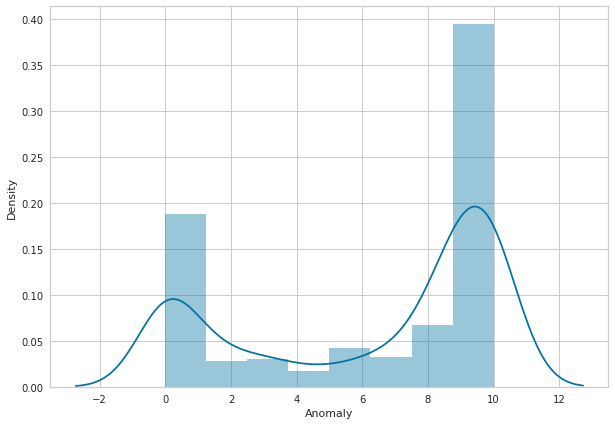

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sns.distplot(ensemble_result)
#ensemble_result

<AxesSubplot:xlabel='LABEL', ylabel='Density'>

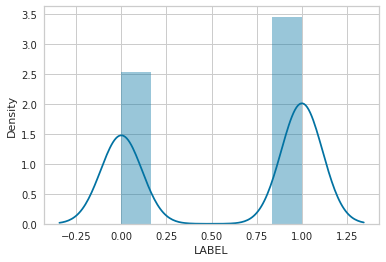

In [23]:
sub['LABEL'] = ensemble_result > 7
sns.distplot(sub['LABEL'])

In [24]:
sub.to_csv('sub.csv', index = False)